# Support Vector Machine
## Анализ данных

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [39]:
PATH = "../../Datasets/ForestFires/"
tr_name = "forestfires.csv"

In [40]:
tr = pd.read_csv(f"{PATH}{tr_name}")

In [41]:
tr.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [42]:
tr.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [43]:
tr.shape

(517, 13)

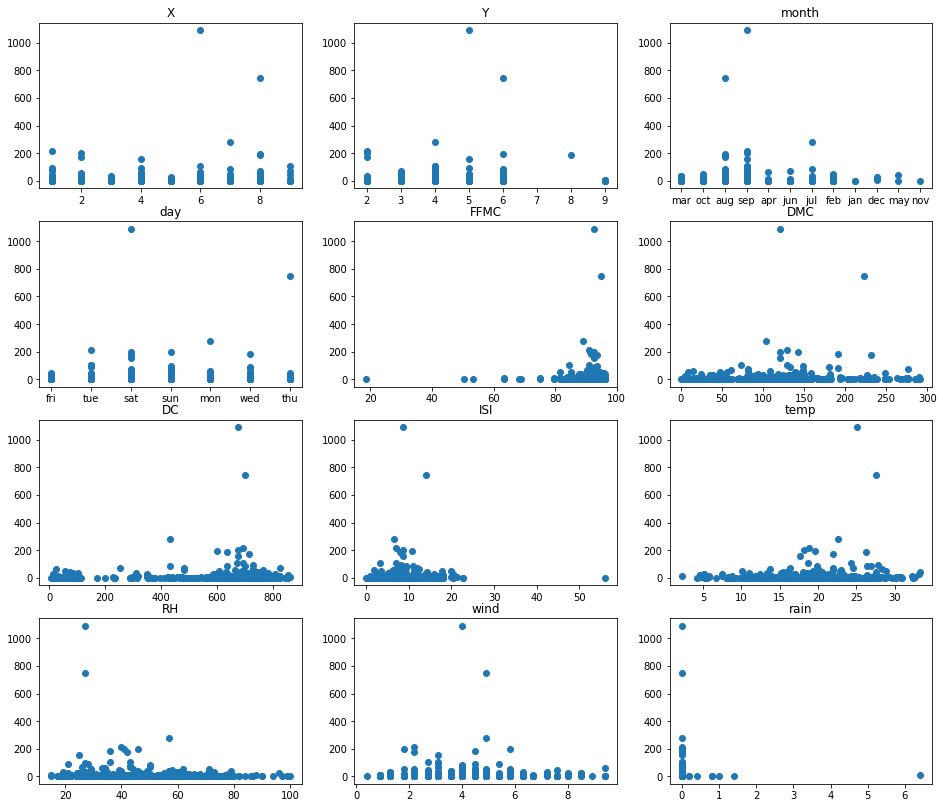

In [44]:
plt.figure(figsize = (16, 14))
for i, col in enumerate(tr.columns[:-1]):
    plt.subplot(4, 3, i+1)
    plt.scatter(tr[col], tr.area)
    plt.title(col)

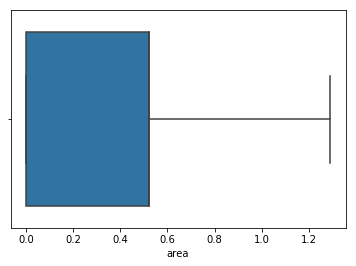

In [56]:
sns.boxplot(tr.area);

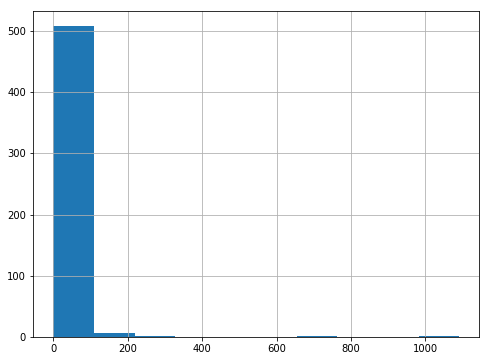

In [46]:
plt.figure(figsize = (8, 6))
tr.area.hist();

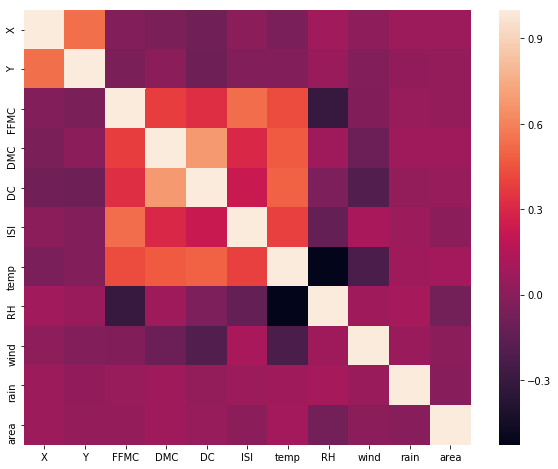

In [47]:
plt.figure(figsize = (10, 8))
sns.heatmap(tr.corr());

## Собираем SVM

In [48]:
tr.month = tr.month.map(dict(zip(tr.month.unique(), range(12))));
tr.day = tr.day.map(dict(zip(tr.day.unique(), range(7))));

In [49]:
median = tr.area.median()

In [50]:
tr.area = tr.area.apply(lambda x: x if x<=1.3 else median)

In [51]:
#tr.area = tr.area.apply(lambda x: np.log(x+1))

In [52]:
X, Y = tr.drop('area', axis = 1), tr.area

In [53]:
svr = SVR()

models = [svr]
models_name = ['svr']

In [58]:
def fit_and_res(model, x, y, show_params = False, fit = True):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)
    if fit:
        model.fit(x_train, y_train)
    mse = mean_squared_error(y_val, model.predict(x_val))
    r2 = explained_variance_score(y_val, model.predict(x_val))
    return (model.best_params_, r2, mse, math.sqrt(mse)) if show_params else (r2, mse, math.sqrt(mse))

In [55]:
res = []
res.append(fit_and_res(models[0], X, Y))
res = pd.DataFrame(np.array(res).T, columns = models_name, index = ['r2', 'mse', 'sqrt'])
res

C:\Users\Fridge\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,svr
r2,0.005411
mse,0.088784
sqrt,0.297967


***
## Tuning

In [60]:
params = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9, 1.4, 2.1], 'C': [0.25, 0.5, 0.75, 1, 10, 100, 1000, 10000, 100000]}]
svrGS = GridSearchCV(svr, params, cv = 5, n_jobs=-1)

In [61]:
fit_and_res(svrGS, X, Y, True)

C:\Users\Fridge\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'C': 0.25, 'gamma': 2.1, 'kernel': 'rbf'},
 0.027653606189827817,
 0.08748127478928111,
 0.295772336078412)

In [59]:
fit_and_res(svrGS, X, Y, fit = False)

(-0.05309799430482287, 0.1340084495560001, 0.36607164538652825)